In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline


In [2]:
import gzip
import pickle

# Load training data
with gzip.open('data/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

# Load test data
with gzip.open('data/test.pkl', 'rb') as f:
    test_data = pickle.load(f)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
datasets = [item['dataset'] for item in train_data]
dataset_counts = Counter(datasets)
print(f"Dataset distribution: {dataset_counts}")


Number of training samples: 65
Number of test samples: 20
Dataset distribution: Counter({'amateur': 46, 'expert': 19})


### Summary of Terms

| Term      | Meaning                                                                                                 |
|-----------|---------------------------------------------------------------------------------------------------------|
| **Video** | The raw echocardiography video (grayscale, 112 × 112 per frame, with 334 frames for this example).       |
| **Box**   | A binary mask that outlines the general region of interest (mitral valve area) in each frame.           |
| **Label** | Ground truth segmentation masks for specific frames in the video, marking the mitral valve pixels.      |
| **Frames**| Indices of frames that have been labeled (e.g., [15, 59, 143]). Only these frames in `label` contain meaningful annotations. |
| **Dataset**| Specifies whether the annotations were created by experts or amateurs, providing insight into the reliability of the labels. |


In [3]:
# Observe the keys in the first training sample
first_item = train_data[0]

video = first_item['video']
box = first_item['box']
label = first_item['label']
frames = first_item['frames']
dataset = first_item['dataset']

print(f"Video shape: {video.shape}") # (height, width, nbr_frames)
print(f"Box shape: {box.shape}") # Act as a crop of region of interest of the video. matches the video shape
print(f"Label shape: {label.shape}") # Mask of the MV. True for MV, False for non-MV, (height, width, nbr_frames)
print(f"Labeled frames for this video: {frames}") # Indices of the frames that have manual annotations. Frames outside this list are not labeled (mask all False)
print(f"Dataset type: {dataset}") # 'expert' or 'amateur'

Video shape: (112, 112, 334)
Box shape: (112, 112)
Label shape: (112, 112, 334)
Labeled frames for this video: [15, 59, 143]
Dataset type: amateur


In [ ]:
def display_frame_and_label(video, label, frame_index):
    frame = video[:, :, frame_index]
    label_frame = label[:, :, frame_index]

    plt.figure(figsize=(5, 2.5))

    # Original Frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame, cmap='gray')
    plt.title(f'Video Frame {frame_index}')
    plt.axis('off')

    # Frame with Label Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(frame, cmap='gray')
    plt.imshow(label_frame, cmap='jet', alpha=0.5)
    plt.title(f'Label Overlay {frame_index}')
    plt.axis('off')

    plt.show()

# Visualize frames with labels of the first training sample (video)
for frame_index in frames:
    display_frame_and_label(video, label, frame_index)

# Display all frames in the first video
#for frame_index in range(video.shape[2]):  # Loop over all frames in the video
#    display_frame_and_label(video, label, frame_index)


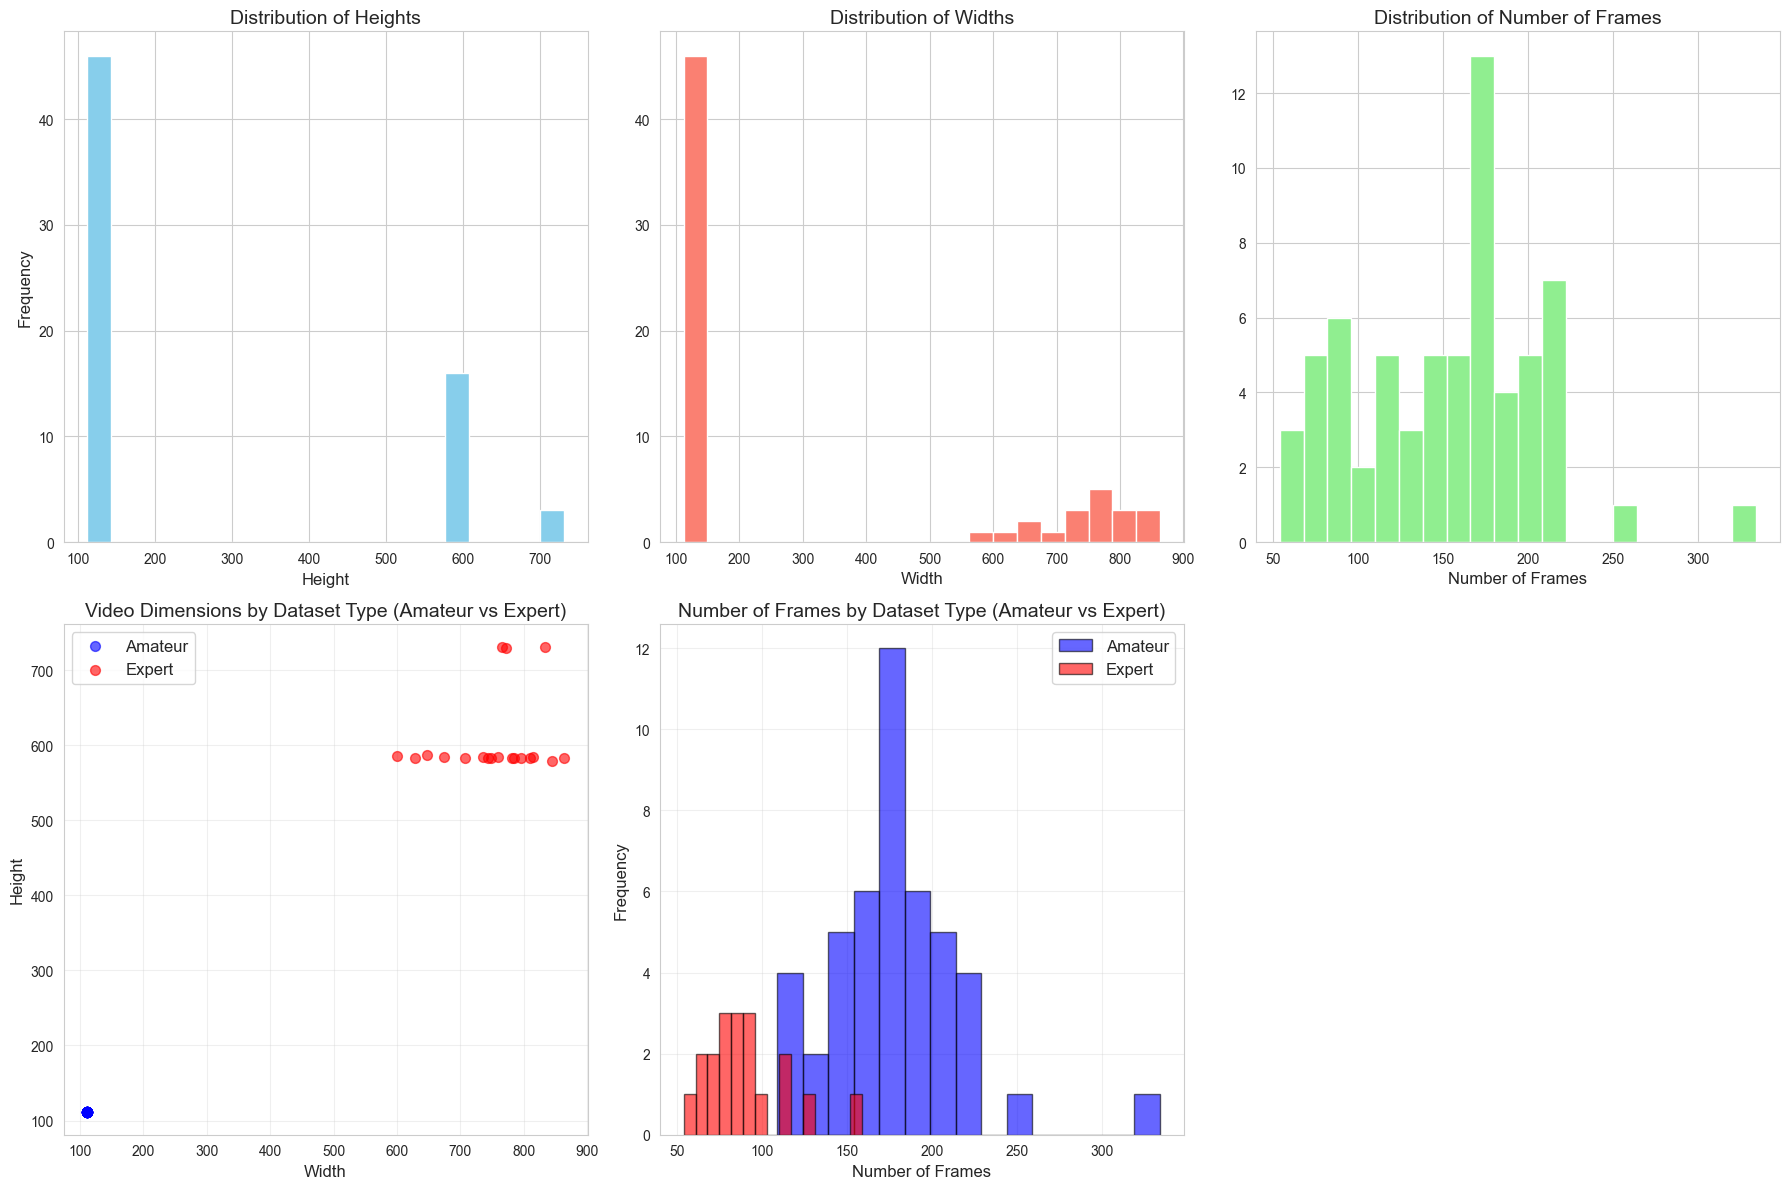

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

heights = [item['video'].shape[0] for item in train_data]
widths = [item['video'].shape[1] for item in train_data]
num_frames = [item['video'].shape[2] for item in train_data]

# First row: Distribution of heights, widths, and number of frames
# Heights
axes[0, 0].hist(heights, bins=20, color='skyblue')
axes[0, 0].set_title('Distribution of Heights', fontsize=14)
axes[0, 0].set_xlabel('Height', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)

# Widths
axes[0, 1].hist(widths, bins=20, color='salmon')
axes[0, 1].set_title('Distribution of Widths', fontsize=14)
axes[0, 1].set_xlabel('Width', fontsize=12)

# Number of Frames
axes[0, 2].hist(num_frames, bins=20, color='lightgreen')
axes[0, 2].set_title('Distribution of Number of Frames', fontsize=14)
axes[0, 2].set_xlabel('Number of Frames', fontsize=12)


# Dimensions of amateur and expert datasets
amateur_heights = [item['video'].shape[0] for item in train_data if item['dataset'] == 'amateur']
amateur_widths = [item['video'].shape[1] for item in train_data if item['dataset'] == 'amateur']
expert_heights = [item['video'].shape[0] for item in train_data if item['dataset'] == 'expert']
expert_widths = [item['video'].shape[1] for item in train_data if item['dataset'] == 'expert']
amateur_frames = [item['video'].shape[2] for item in train_data if item['dataset'] == 'amateur']
expert_frames = [item['video'].shape[2] for item in train_data if item['dataset'] == 'expert']


# Second row: Dimensions scatter plot and number of frames histogram (expert vs amateur)
# Left plot: Dimensions scatter plot
axes[1, 0].scatter(amateur_widths, amateur_heights, color='blue', alpha=0.6, label='Amateur', s=50)
axes[1, 0].scatter(expert_widths, expert_heights, color='red', alpha=0.6, label='Expert', s=50)
axes[1, 0].set_title('Video Dimensions by Dataset Type (Amateur vs Expert)', fontsize=14)
axes[1, 0].set_xlabel('Width', fontsize=12)
axes[1, 0].set_ylabel('Height', fontsize=12)
axes[1, 0].legend(fontsize=12)
axes[1, 0].grid(alpha=0.3)

# Right plot: Number of frames histogram
axes[1, 1].hist(amateur_frames, bins=15, color='blue', alpha=0.6, label='Amateur', edgecolor='black')
axes[1, 1].hist(expert_frames, bins=15, color='red', alpha=0.6, label='Expert', edgecolor='black')
axes[1, 1].set_title('Number of Frames by Dataset Type (Amateur vs Expert)', fontsize=14)
axes[1, 1].set_xlabel('Number of Frames', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend(fontsize=12)
axes[1, 1].grid(alpha=0.3)

# Turn off the empty subplot in the second row
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()



In [9]:
def plot_video_frames_with_masks(data, category='expert', num_videos_to_plot=3):
    """
    Plots the labeled frames for videos in the specified category (amateur or expert).

    Parameters:
        data (list): The list of dictionaries containing video data.
        category (str): The category of videos to plot ('amateur' or 'expert').
        num_videos_to_plot (int or 'all'): Number of videos to plot. Use 'all' to plot all videos.
    """
    # Filter videos based on the category
    selected_videos = [item for item in data if item['dataset'] == category]
    if num_videos_to_plot == 'all':
        num_videos = len(selected_videos)
    else:
        num_videos = min(len(selected_videos), num_videos_to_plot)

    if num_videos == 0:
        print(f"No videos found in the '{category}' category.")
        return

    # Prepare the plot
    fig, axes = plt.subplots(num_videos, 9, figsize=(15, 5 * num_videos))
    fig.suptitle(f"Labeled Frames of {category.capitalize()} Videos (With and Without Masks)", fontsize=16, y=0.92)

    for i, video_data in enumerate(selected_videos[:num_videos]):
        video = video_data['video']
        label = video_data['label']
        frames = video_data['frames']
        box = video_data['box']

        for j, frame_idx in enumerate(frames):
            frame = video[:, :, frame_idx]
            mask = label[:, :, frame_idx]

            # Plot the frame without mask
            ax1 = axes[i, j * 3]
            ax1.imshow(frame, cmap='gray')
            ax1.set_title(f"Frame {frame_idx} (Video {i+1})")
            ax1.axis('off')

            # Plot the frame with mask overlay
            ax2 = axes[i, j * 3 + 1]
            ax2.imshow(frame, cmap='gray')
            ax2.imshow(mask, cmap='jet', alpha=0.5)
            ax2.set_title(f"Frame {frame_idx} + Mask")
            ax2.axis('off')

            ax3 = ax2 = axes[i, j * 3 + 2]
            ax3.imshow(frame, cmap='gray')
            ax3.imshow(box, cmap='jet', alpha=0.5)
            ax3.set_title(f"Frame {frame_idx} + Box")
            ax3.axis('off')

    plt.tight_layout()
    plt.show()

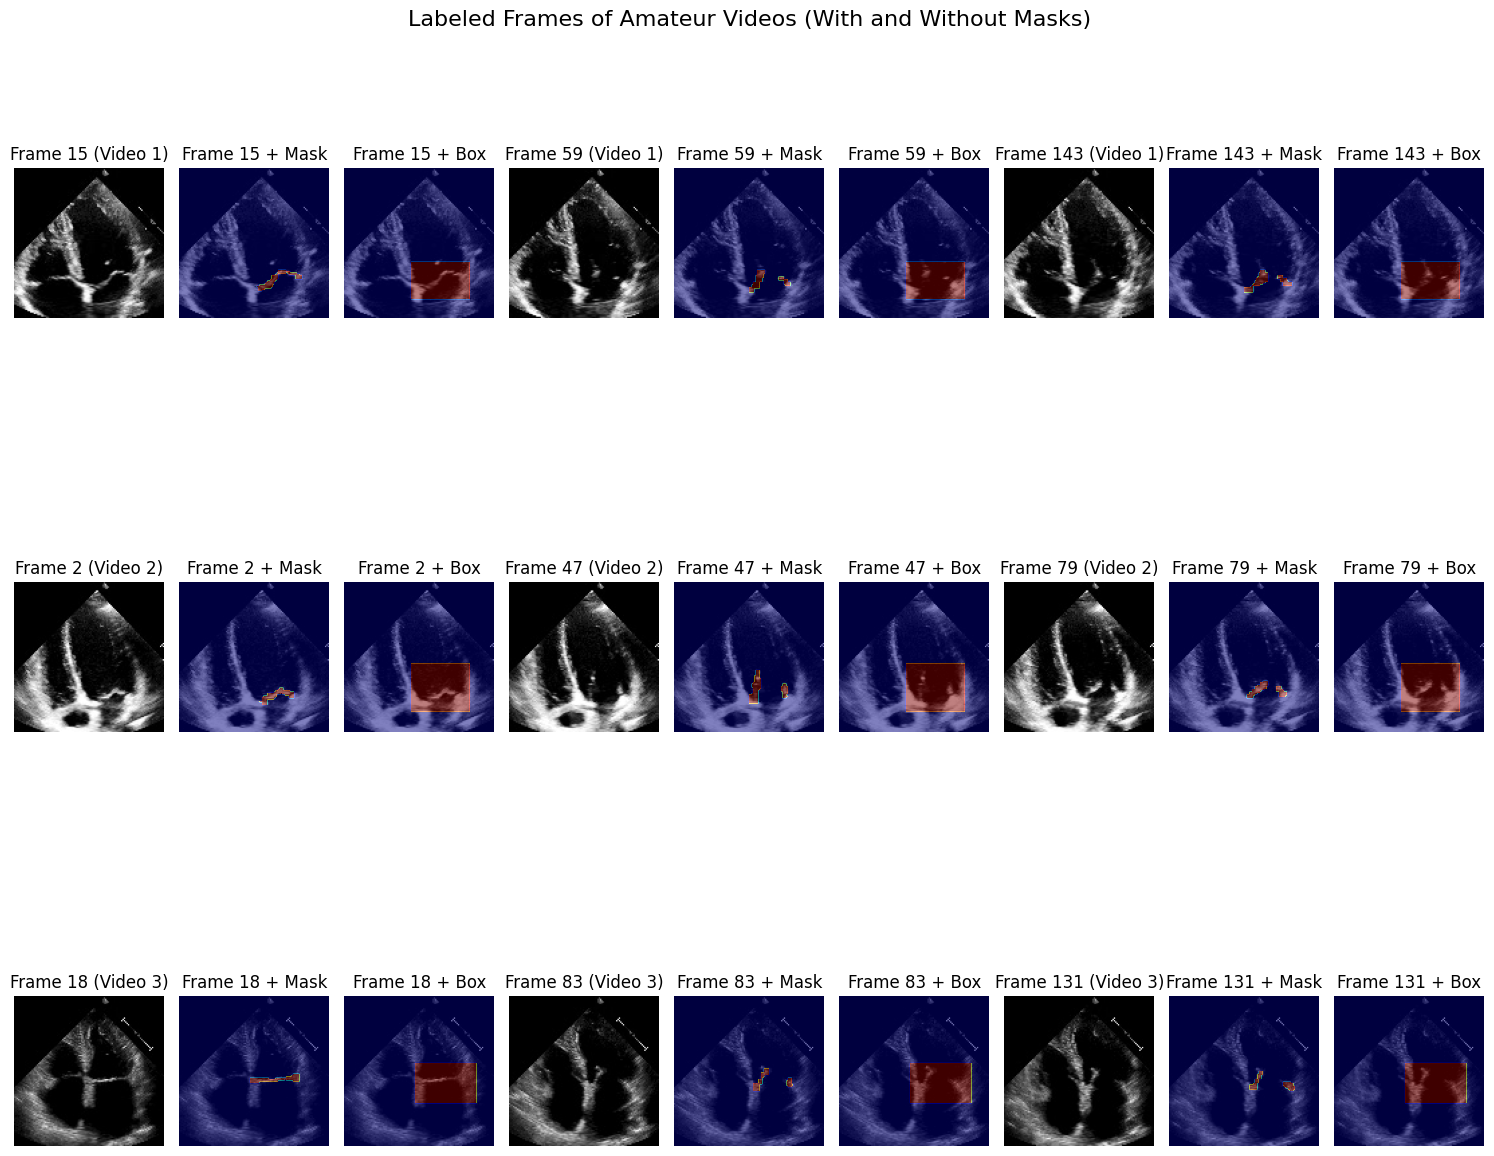

In [10]:
plot_video_frames_with_masks(train_data, category="amateur", num_videos_to_plot=3)

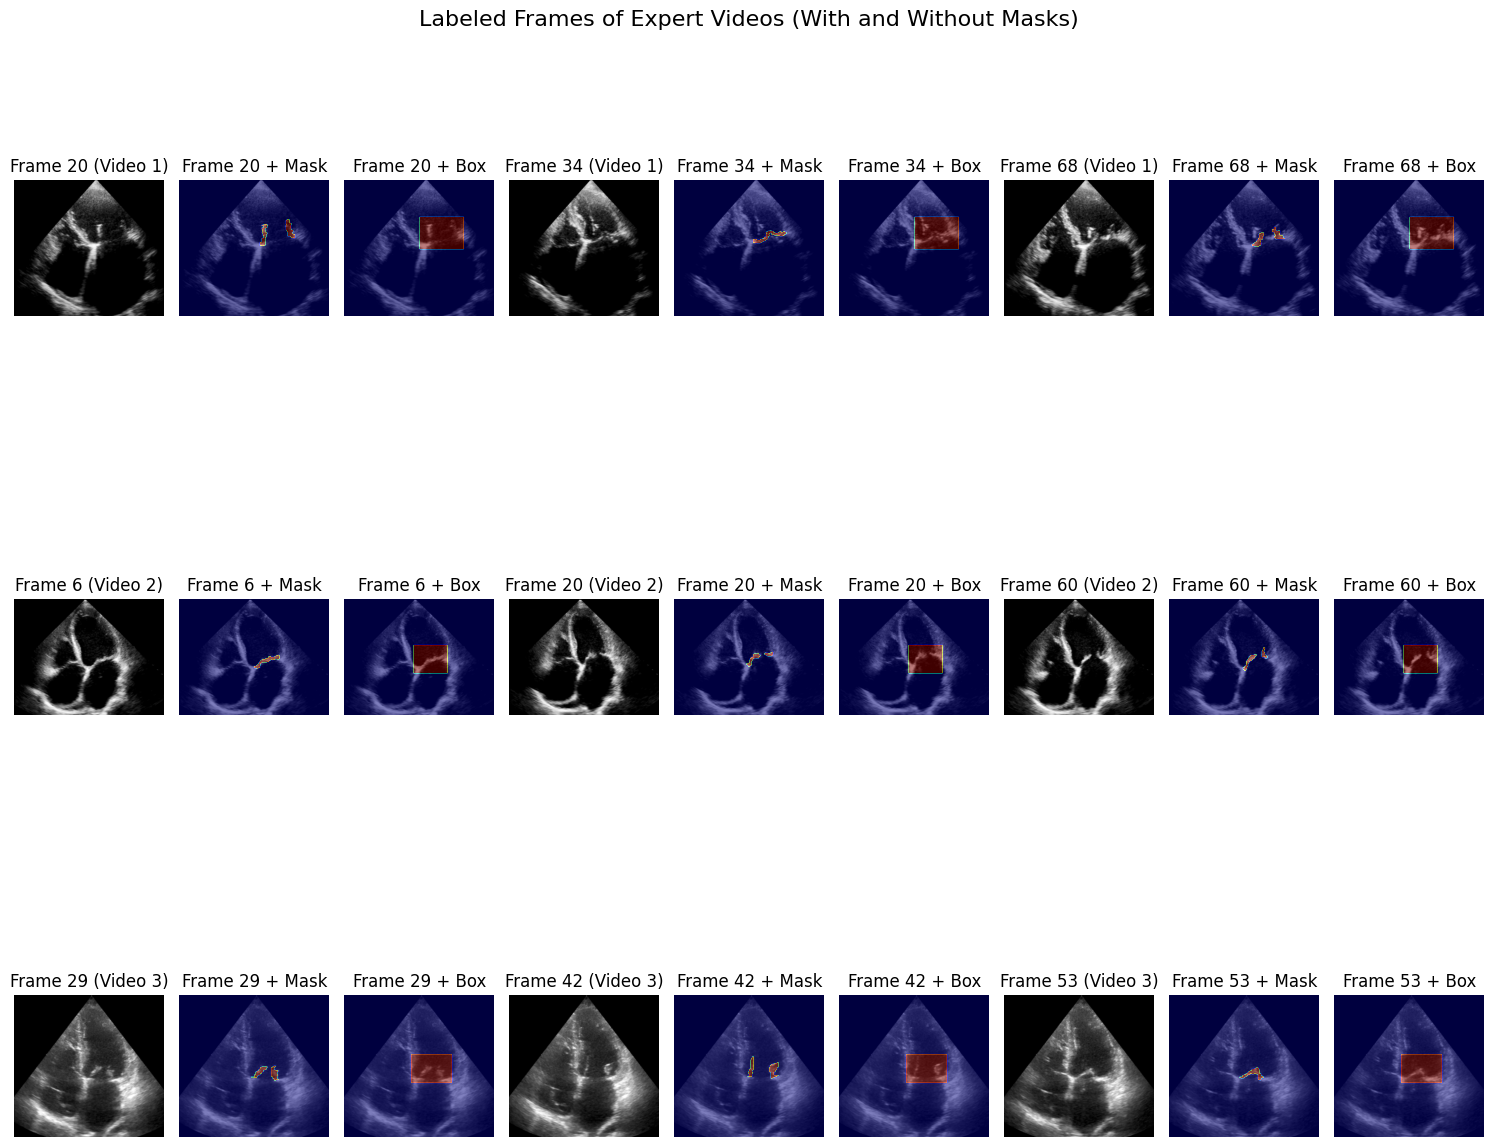

In [11]:
plot_video_frames_with_masks(train_data, category="expert", num_videos_to_plot=3)